# 🏋️ Model Training

## ⚙️ Setup 

### 📚 Importing Libraries

Importing from packages

In [1]:
import os
import gc
import time
from dotenv import load_dotenv

import pandas as pd
import numpy as np
import torch
from torch import nn
import wandb
from pprint import pprint
import warnings

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
os.chdir("../")
warnings.filterwarnings("ignore")
load_dotenv()

True

Importing user defined packages

In [3]:
from lib.config import config
from lib.paths import Paths
from lib.model.epoch_functions import train_epoch, valid_epoch
from lib.model.utils import get_score, get_model_optimizer_and_scheduler
from lib.utils.utils import seed_everything
from lib.data import read_data_loader_from_disk
from lib.criterion.metrics import log_metrics

In [4]:
pprint(config)

namespace(apex=True,
          batch_scheduler=True,
          batch_size_train=32,
          batch_size_valid=32,
          betas=[0.9, 0.999],
          data_version=5,
          debug=False,
          decoder_lr=2e-05,
          encoder_lr=2e-05,
          epochs=2,
          eps=1e-06,
          gradient_accumulation_steps=1,
          gradient_checkpointing=True,
          max_grad_norm=1000,
          max_length=512,
          min_lr=1e-06,
          model='microsoft/deberta-v3-xsmall',
          n_folds=5,
          negative_sample=False,
          negative_sample_partitions=3,
          num_classes=6,
          num_cycles=0.5,
          num_warmup_steps=0,
          num_workers=6,
          print_freq=6,
          random_seed=20,
          scheduler='cosine',
          stride=192,
          tokenizer_version=2,
          train=True,
          train_folds=[0, 1, 2, 3, 4, 5, 6, 7],
          weight_decay=0.01)


In [5]:
seed_everything()

### Setting Up WandB

In [6]:
WANDB_PROJECT = "Kaggle_ASE_2.0"
model_name = config.model.split("/")[-1]
WANDB_NAME = f"{model_name}-{config.max_length}-D{config.data_version}-T{config.tokenizer_version}"

In [7]:
wandb.login(key=os.environ.get('WANDB_API_KEY'))
wandb.init(
    project=WANDB_PROJECT,
    name=WANDB_NAME,
    save_code=True,
    job_type="train",
    config=config,
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shakleenishfar (laplacesdemon43). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ishfar/.netrc


## 📖 Definitions

### 🌎 Global Variables

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The competition data has a class imbalance problem. Which is why I assign higher weights to classes having lower samples.

In [9]:
# class_weights = torch.tensor([1.0, 0.25, 0.25, 0.5, 1.0, 2.0]).to(device)
class_weights = torch.tensor([1.0] * 6).to(device)

### 🛠️ Functions

In [10]:
def train_loop(fold):
    print(f"========== Fold: {fold} training ==========")

    # ======== DATA LOADER ==========
    train_loader, valid_loader = read_data_loader_from_disk(fold)
    valid_fold = pd.read_csv(os.path.join(Paths.DATA_LOADER_PATH, f"valid_{fold}.csv"))
    valid_labels = valid_fold["score"].values

    # ======== MODEL ==========
    model, optimizer, scheduler = get_model_optimizer_and_scheduler(
        train_loader, device
    )

    # ======= LOSS ==========
    # criterion = RMSELoss(reduction="mean") # nn.SmoothL1Loss(reduction='mean')
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    softmax = nn.Softmax(dim=1)

    best_score = -np.inf
    # ====== ITERATE EPOCHS ========
    for epoch in range(config.epochs):
        start_time = time.time()

        # ======= TRAIN ==========
        avg_loss = train_epoch(
            fold,
            train_loader,
            model,
            criterion,
            optimizer,
            epoch,
            scheduler,
            device,
        )

        # ======= EVALUATION ==========
        avg_val_loss, prediction_dict = valid_epoch(
            fold, valid_loader, model, criterion, device
        )
        predictions = prediction_dict["predictions"]
        _, predictions = torch.max(softmax(torch.tensor(predictions)), dim=1)

        # ======= SCORING ==========
        score = get_score(valid_labels, predictions)

        wandb.log(
            {
                f"eval/eval_epoch_f{fold}": epoch + 1,
                f"eval/eval_loss_f{fold}": avg_val_loss,
                f"eval/qwk_score_f{fold}": score,
            }
        )

        elapsed = time.time() - start_time

        print(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        print(f"Epoch {epoch+1} - Score: {score:.4f}")

        if score > best_score:
            best_score = score
            print(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "predictions": predictions},
                Paths.MODEL_OUTPUT_PATH
                + f"/{config.model.replace('/', '_')}_fold_{fold}_best.pth",
            )

    predictions = torch.load(
        Paths.MODEL_OUTPUT_PATH
        + f"/{config.model.replace('/', '_')}_fold_{fold}_best.pth",
        map_location=torch.device("cpu"),
    )["predictions"]
    valid_fold["pred_score"] = predictions

    del model, optimizer, scheduler, criterion, softmax
    torch.cuda.empty_cache()
    gc.collect()

    return valid_fold

In [11]:
def get_result(oof_df):
    labels = oof_df["score"].values
    preds = oof_df["pred_score"].values
    score = get_score(labels, preds)
    print(f'Score: {score:<.4f}')
    return score

## 🏁 Start Training

In [12]:
if config.train:
    oof_df = pd.DataFrame()

    for fold in range(config.n_folds):
        if fold in config.train_folds:
            _oof_df = train_loop(fold)
            log_metrics(_oof_df, f"Fold {fold}")
            oof_df = pd.concat([oof_df, _oof_df])
            print(f"========== Fold: {fold} result ==========")
            get_result(_oof_df)

    oof_df = oof_df.reset_index(drop=True)
    print(f"========== CV ==========")
    score = get_result(oof_df)
    wandb.log({"CV/qwk_score": score})
    oof_df.to_csv(Paths.MODEL_OUTPUT_PATH + "/oof_df.csv", index=False)

========== Fold: 0 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 0: 100%|██████████| 149/149 [00:25<00:00,  5.87valid_batch/s]


Epoch 1 - avg_train_loss: 1.0544  avg_val_loss: 0.9822  time: 456s
Epoch 1 - Score: 0.7619
Epoch 1 - Save Best Score: 0.7619 Model


Validating Fold 0: 100%|██████████| 149/149 [00:24<00:00,  5.98valid_batch/s]


Epoch 2 - avg_train_loss: 0.8693  avg_val_loss: 0.9266  time: 453s
Epoch 2 - Score: 0.8077
Epoch 2 - Save Best Score: 0.8077 Model
========== Fold: 0 result ==========
Score: 0.8077
========== Fold: 1 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 1: 100%|██████████| 150/150 [00:24<00:00,  6.03valid_batch/s]


Epoch 1 - avg_train_loss: 1.0390  avg_val_loss: 0.9303  time: 452s
Epoch 1 - Score: 0.7898
Epoch 1 - Save Best Score: 0.7898 Model


Validating Fold 1: 100%|██████████| 150/150 [00:24<00:00,  6.11valid_batch/s]


Epoch 2 - avg_train_loss: 0.8744  avg_val_loss: 0.9760  time: 448s
Epoch 2 - Score: 0.7885
========== Fold: 1 result ==========
Score: 0.7898
========== Fold: 2 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 2: 100%|██████████| 149/149 [00:23<00:00,  6.36valid_batch/s]


Epoch 1 - avg_train_loss: 1.0384  avg_val_loss: 1.1000  time: 442s
Epoch 1 - Score: 0.7374
Epoch 1 - Save Best Score: 0.7374 Model


Validating Fold 2: 100%|██████████| 149/149 [00:24<00:00,  6.05valid_batch/s]


Epoch 2 - avg_train_loss: 0.8689  avg_val_loss: 0.9403  time: 428s
Epoch 2 - Score: 0.7953
Epoch 2 - Save Best Score: 0.7953 Model
========== Fold: 2 result ==========
Score: 0.7953
========== Fold: 3 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 3: 100%|██████████| 148/148 [00:22<00:00,  6.58valid_batch/s]


Epoch 1 - avg_train_loss: 1.0457  avg_val_loss: 0.9905  time: 439s
Epoch 1 - Score: 0.7638
Epoch 1 - Save Best Score: 0.7638 Model


Validating Fold 3: 100%|██████████| 148/148 [00:24<00:00,  6.00valid_batch/s]


Epoch 2 - avg_train_loss: 0.8803  avg_val_loss: 0.9469  time: 450s
Epoch 2 - Score: 0.7717
Epoch 2 - Save Best Score: 0.7717 Model
========== Fold: 3 result ==========
Score: 0.7717
========== Fold: 4 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 4: 100%|██████████| 150/150 [00:25<00:00,  5.94valid_batch/s]


Epoch 1 - avg_train_loss: 1.0570  avg_val_loss: 1.0048  time: 453s
Epoch 1 - Score: 0.7526
Epoch 1 - Save Best Score: 0.7526 Model


Validating Fold 4: 100%|██████████| 150/150 [00:22<00:00,  6.59valid_batch/s]


Epoch 2 - avg_train_loss: 0.8927  avg_val_loss: 0.9433  time: 442s
Epoch 2 - Score: 0.7879
Epoch 2 - Save Best Score: 0.7879 Model
========== Fold: 4 result ==========
Score: 0.7879
========== CV ==========
Score: 0.7911


In [13]:
wandb.log({"oof_table": wandb.Table(dataframe=oof_df)})

## Evaluate

In [14]:
log_metrics(oof_df, "Overall")

### Confusion Matrix

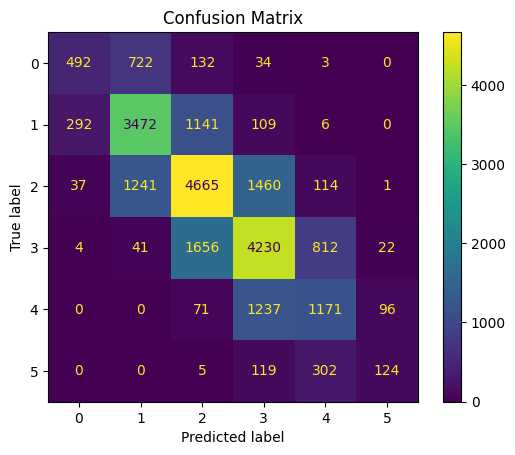

In [15]:
cm = confusion_matrix(oof_df["score"], oof_df["pred_score"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(config.num_classes)))

# Plot the confusion matrix
disp.plot(cmap='viridis', values_format='d')
plt.title("Confusion Matrix")
plt.show()

Finish experiment

In [16]:
wandb.finish()

CV/qwk_score,▁
eval/eval_epoch_f0,▁█
eval/eval_epoch_f1,▁█
eval/eval_epoch_f2,▁█
eval/eval_epoch_f3,▁█
eval/eval_epoch_f4,▁█
eval/eval_loss_f0,█▁
eval/eval_loss_f1,▁█
eval/eval_loss_f2,█▁
eval/eval_loss_f3,█▁
eval/eval_loss_f4,█▁
